In [6]:
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import torch

h5_file = 'dataset/VBF.h5'

In [7]:
def hdf5_jet_flavor(filename):
    """Read *.h5 files and return the jet flavor."""

    with h5py.File(filename, 'r') as f:
        # 1 : d, 2 : u, 3 : s, 4 : c, 5 : b, 21 : g

        J1 = np.array(f['J1']['flavor'][:])
        J1 = torch.from_numpy(J1).long()

        J2 = np.array(f['J2']['flavor'][:])
        J2 = torch.from_numpy(J2).long()

        J1_q = (J1 != 21)  # Quark (1~5) + Unknown (0)
        J1_g = (J1 == 21)  # Gluon (21)

        J2_q = (J2 != 21)
        J2_g = (J2 == 21)

        J_2q0g = (J1_q & J2_q)
        J_1q1g = (J1_q & J2_g) | (J1_g & J2_q)
        J_0q2g = (J1_g & J2_g)

    return {'2q0g': J_2q0g, '1q1g': J_1q1g, '0q2g': J_0q2g, 'total': len(J1)}

GGF = hdf5_jet_flavor('dataset/GGF.h5')
VBF = hdf5_jet_flavor('dataset/VBF.h5')

L = 3000
BR_Haa = 0.00227
cross_section_GGF = 54.67 * 1000
cross_section_VBF = 4.278 * 1000

GGF_after_selection = cross_section_GGF * BR_Haa * L * 0.09
GGF_2q0g = sum(GGF['2q0g']) / GGF['total'] * GGF_after_selection
GGF_1q1g = sum(GGF['1q1g']) / GGF['total'] * GGF_after_selection
GGF_0q2g = sum(GGF['0q2g']) / GGF['total'] * GGF_after_selection

VBF_After_selection = cross_section_VBF * BR_Haa * L * 0.41
VBF_2q0g = sum(VBF['2q0g']) / VBF['total'] * VBF_After_selection
VBF_1q1g = sum(VBF['1q1g']) / VBF['total'] * VBF_After_selection
VBF_0q2g = sum(VBF['0q2g']) / VBF['total'] * VBF_After_selection

print(f"# GGFs: 2q0g: {int(GGF_2q0g)}, 1q1g: {int(GGF_1q1g)}, 0q2g: {int(GGF_0q2g)}")
print(f"# VBFs: 2q0g: {int(VBF_2q0g)}, 1q1g: {int(VBF_1q1g)}, 0q2g: {int(VBF_0q2g)}")

# GGFs: 2q0g: 16295, 1q1g: 13666, 0q2g: 3544
# VBFs: 2q0g: 10310, 1q1g: 1579, 0q2g: 53


In [8]:
with h5py.File(h5_file, 'r') as f:
    for group_name in f.keys():
        group = f[group_name]
        print(f"Group: {group_name}")
        for dataset_name in group.keys():
            dataset = group[dataset_name]
            print(f"  Dataset: {dataset_name}, shape = {dataset.shape}, dtype = {dataset.dtype}")

Group: EVENT
  Dataset: deta, shape = (332187,), dtype = float32
  Dataset: mjj, shape = (332187,), dtype = float32
  Dataset: type, shape = (332187,), dtype = int64
Group: J1
  Dataset: eta, shape = (332187, 50), dtype = float32
  Dataset: flavor, shape = (332187,), dtype = int64
  Dataset: mask, shape = (332187, 50), dtype = bool
  Dataset: phi, shape = (332187, 50), dtype = float32
  Dataset: pt, shape = (332187, 50), dtype = float32
Group: J2
  Dataset: eta, shape = (332187, 50), dtype = float32
  Dataset: flavor, shape = (332187,), dtype = int64
  Dataset: mask, shape = (332187, 50), dtype = bool
  Dataset: phi, shape = (332187, 50), dtype = float32
  Dataset: pt, shape = (332187, 50), dtype = float32
Group: PHOTON
  Dataset: eta, shape = (332187, 2), dtype = float32
  Dataset: phi, shape = (332187, 2), dtype = float32
  Dataset: pt, shape = (332187, 2), dtype = float32
Group: TOWER
  Dataset: eta, shape = (332187, 250), dtype = float32
  Dataset: mask, shape = (332187, 250), dtyp

In [9]:
with h5py.File(h5_file, 'r') as f:
    N = f['EVENT']['mjj'].shape[0]
    
    mjj = f['EVENT']['mjj'][:]
    deta = f['EVENT']['deta'][:]
    label = f['EVENT']['type'][:]  # 0: GGF, 1: VBF, etc.

    photon_pt = f['PHOTON']['pt'][:, :2]    # shape (N, 2)
    photon_eta = f['PHOTON']['eta'][:, :2]
    photon_phi = f['PHOTON']['phi'][:, :2]

    # Load tower info
    tower_pt = f['TOWER']['pt'][:]
    tower_phi = f['TOWER']['phi'][:]
    tower_mask = f['TOWER']['mask'][:]

    # Compute px and py
    tower_px = tower_pt * np.cos(tower_phi)
    tower_py = tower_pt * np.sin(tower_phi)

    # Apply mask (set masked towers to 0)
    tower_px *= tower_mask
    tower_py *= tower_mask

    # Sum vector components
    sum_px = np.sum(tower_px, axis=1)
    sum_py = np.sum(tower_py, axis=1)

    # Compute true vector pt
    tower_pt_vecsum = np.sqrt(sum_px**2 + sum_py**2)


    # Combine into one big feature array
    X = np.column_stack([
        mjj,
        deta,
        photon_pt[:, 0], photon_eta[:, 0], photon_phi[:, 0],
        photon_pt[:, 1], photon_eta[:, 1], photon_phi[:, 1],
        tower_pt_vecsum
    ])

X.shape

(332187, 9)

Images shape: (332187, 3, 40, 40)


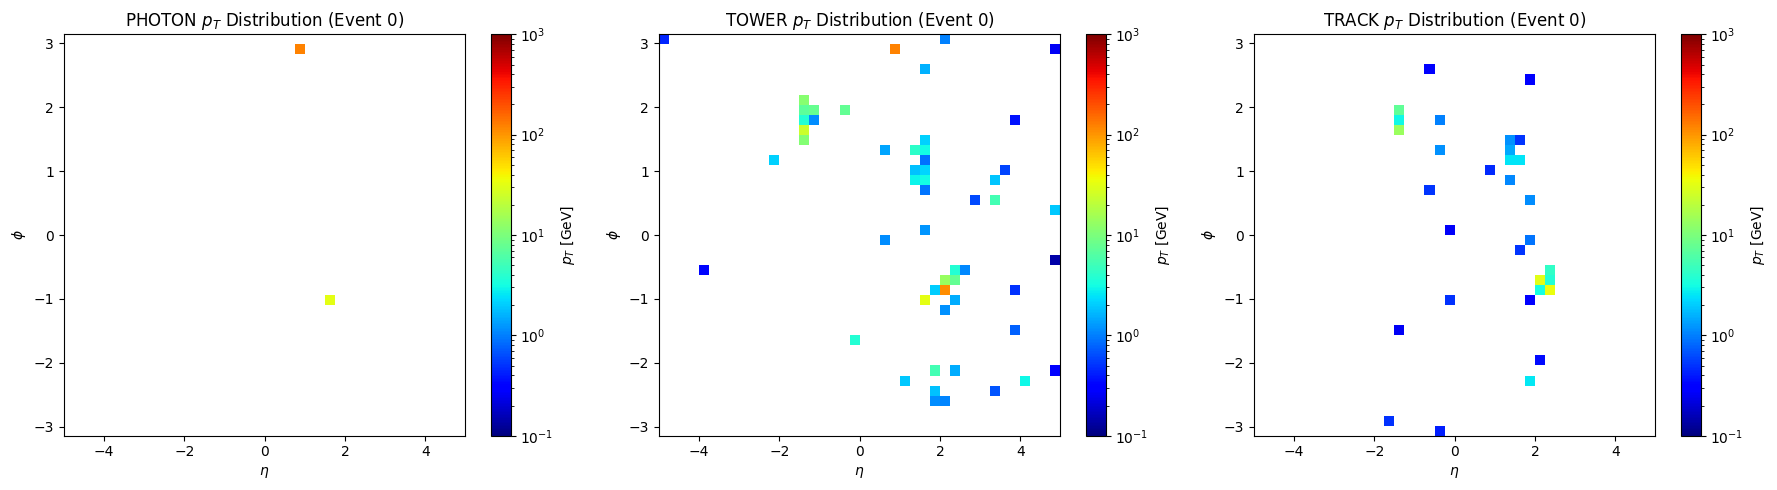

In [11]:
channels = ['PHOTON', 'TOWER', 'TRACK']
grid_size = 40  # Define grid size

phi_bins = np.linspace(-np.pi, np.pi, grid_size + 1)
eta_bins = np.linspace(-5, 5, grid_size + 1)

with h5py.File(h5_file, 'r') as f:
    images = []
    
    for channel in channels:
        pt = f[channel]['pt'][:]
        eta = f[channel]['eta'][:]
        phi = f[channel]['phi'][:]

        # Apply mask if available
        if 'mask' in f[channel]:
            mask = f[channel]['mask'][:]
            pt = pt * mask
        
        # Get shapes: N events, M indices per event.
        N, M = pt.shape

        # Initialize the image array for the current channel
        image = np.zeros((N, grid_size, grid_size))  # (N, L, L)
        
        # Compute indices for phi and eta
        phi_indices = np.digitize(phi, phi_bins) - 1  # (N, M)
        eta_indices = np.digitize(eta, eta_bins) - 1  # (N, M)
        
        # Ensure indices are within bounds
        phi_indices = np.clip(phi_indices, 0, grid_size - 1)
        eta_indices = np.clip(eta_indices, 0, grid_size - 1)
        
        # Create indexing arrays by flattening the 2D arrays.
        event_idx = np.repeat(np.arange(N), M)  # (N * M,)
        phi_idx = phi_indices.reshape(-1)   # (N * M,)
        eta_idx = eta_indices.reshape(-1)   # (N * M,)
        pt_flat = pt.reshape(-1)            # (N * M,)
        
        # Use np.add.at to accumulate the pt values at the corresponding indices.
        np.add.at(image, (event_idx, phi_idx, eta_idx), pt_flat)

        images.append(image)
    
    # Concatenate images along the channel axis
    images = np.stack(images, axis=1)

print("Images shape:", images.shape)

# ---------------- Plotting with subplots (1 row, 3 columns) ----------------

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, channel in enumerate(channels):
    # Select the first event's image for the current channel
    data = images[0, i, :, :]

    # Mask zeros for proper log scaling
    data_masked = np.ma.masked_where(data == 0, data)
    
    # Plot using pcolormesh. Note: pcolormesh expects bin edges.
    c = axs[i].pcolormesh(eta_bins, phi_bins, data_masked,
            norm=LogNorm(vmin=0.1, vmax=1e3), cmap='jet')
    axs[i].set_xlabel(r'$\eta$')
    axs[i].set_ylabel(r'$\phi$')
    axs[i].set_title(f"{channel} $p_T$ Distribution (Event 0)")
    fig.colorbar(c, ax=axs[i], label=r'$p_T$ [GeV]')

plt.tight_layout()
plt.show()